<!-- ![RWTH Logo](https://www.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaaaaagazb) -->
![iAMB Logo](https://www.iamb.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaaaanwtny)
# Calculations of Substrate and Production Rates and Yields

* Execute a single cell: <span class="fa-play fa"></span>
* Execute all cells: Menu: Run <span class="fa-chevron-right fa"></span> Run All Cells
* To reboot kernel: <span class="fa-refresh fa"></span>

Find more in the reference (menu: Help <span class="fa-chevron-right fa"></span> Jupyter Reference).

In [1]:
import os
import pandas as pd
# import numpy as np
from datetime import date
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

from cobra.io import read_sbml_model, write_sbml_model
from iambcodes.cobra import *


## Data loading and variables setup

In [2]:
Today = date.today().strftime('%y%m%d')
BaseDir = '/home/ulf/Documents/Ustilago_maydis-GEM/'
TargetDir = os.path.join(BaseDir, 'data/Simulations')
ImageType = 'svg'
SBMLFile = 'iUma22_Curated.xml' #'iCL1079.xml'
SBMLAddress = os.path.join(BaseDir, 'model', SBMLFile)

model = read_sbml_model(SBMLAddress)
model


<Model UMAY at 0x7fb4745c0160>

### Substrate tests
In the following code, the model is tested for growth rates on defined substrates and the corresponding uptake rates.

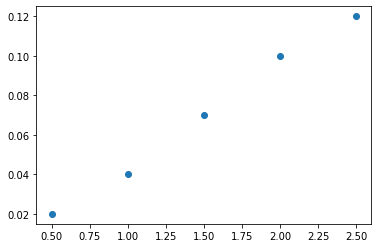

In [32]:
SubNames = ['EX_glc__D_e','EX_glc__D_e','EX_glc__D_e','EX_glc__D_e','EX_glc__D_e']
SubRates = [.5, 1, 1.5, 2, 2.5]

Growth = list()
for myName, myRate in zip(SubNames, SubRates):
    Growth.append(TestSubstrate(model, EX_Sub_Act=[myName], EX_Sub_Off=['EX_glc__D_e'], Rate=myRate))
    
plt.plot(SubRates, Growth, 'o')

#### Plotting simulation and measured growth

Yield: 0.47 gCDW/g (+/-0.03)
NGAM glucose requirement: 0.2 mmol/gCDW/h


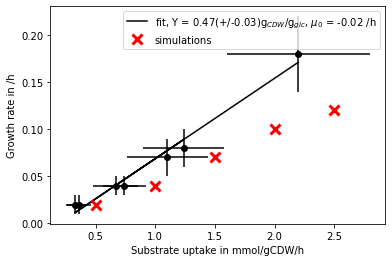

Growth rate versus substrate uptake figure saved as /home/ulf/Documents/Ustilago_maydis-GEM/data/Simulations/220210_RatesCompare_GrowthVsSubRate.svg


In [34]:
RCFile = 'RatesCompare.xlsx'
RCSheet = 'RateCompare'
FigureGrowth = '{}_{}_GrowthVsSubRate.{}'.format(Today, os.path.splitext(RCFile)[0], ImageType)
FigureGrowthPath = os.path.join(TargetDir, FigureGrowth)
RCAddress = os.path.join(BaseDir, 'data', 'GrowthRates', RCFile)
IgnoreDat = None # np.array([5]) # if the file contains any data not to be considered in analysis
SubstrateCorr = 1/.18

RateComp = pd.read_excel(RCAddress, sheet_name=RCSheet)
# ignoring any data points
if IgnoreDat is not None:
    GrowthVal = RateComp.drop(IgnoreDat)['Growth-Rate-/h'].values
    SubVal = RateComp.drop(IgnoreDat)['Substrate-uptake-mmol/gCDW/h'].values
    GVstd =  RateComp.drop(IgnoreDat)['Growth-Rate-Std'].values
    SVstd = RateComp.drop(IgnoreDat)['Uptake-Std'].values
else:
    GrowthVal = RateComp['Growth-Rate-/h'].values
    SubVal = RateComp['Substrate-uptake-mmol/gCDW/h'].values
    GVstd =  RateComp['Growth-Rate-Std'].values
    SVstd = RateComp['Uptake-Std'].values

GrowthAcc, S0, r2, _, GrowthAcc_sterr = stats.linregress(SubVal, GrowthVal)
GrowthAcc_gg = round(GrowthAcc*SubstrateCorr,2)
GrowthAcc_sterr_gg = round(GrowthAcc_sterr*SubstrateCorr,2)
NGAM = round(-S0/GrowthAcc,2)
print('Yield: {} gCDW/g (+/-{})'.format(GrowthAcc_gg, GrowthAcc_sterr_gg))
print('NGAM glucose requirement: {} mmol/gCDW/h'.format(NGAM))
# Growth rate VS Substrate uptake plot
plt.errorbar(SubVal, GrowthVal, xerr=SVstd, yerr=GVstd, fmt='ok') #, 'xk', label='Substrate uptake'
plt.plot(SubVal, S0+GrowthAcc*SubVal, '-k', label=r'fit, Y = {}(+/-{})g$_{{CDW}}$/g$_{{glc}}$, $\mu_0$ = {} /h'.format(GrowthAcc_gg, GrowthAcc_sterr_gg, round(S0,2)))


# RateComp = pd.read_excel(RCFile, sheet_name=RCSheet)
# # Substrate acceleration plot
# plt.errorbar(RateComp['Substrate-uptake-mmol/gCDW/h'], RateComp['Growth-Rate-/h'], xerr=RateComp['Uptake-Std'], yerr=RateComp['Growth-Rate-Std'], fmt='ok', label='exp. growth rates') #, 'xk', label='Substrate uptake'
# # plt.plot(RateComp['Growth-Rate'], SA_ic+SubAcc*RateComp['Growth-Rate'], '-k', label='fit, accel.{}(+/-{})mmol/gCDW/h/h'.format(round(SubAcc,2), round(SA_sl_sterr,2)))
# plt.title('Growth rate VS substrate uptake')
plt.xlabel('Substrate uptake in mmol/gCDW/h')
plt.ylabel('Growth rate in /h')
plt.plot(SubRates, Growth, 'xr', label='simulations', ms=10, markeredgewidth=3)
plt.legend()
plt.savefig(FigureGrowthPath)
plt.show()
print('Growth rate versus substrate uptake figure saved as {}'.format(FigureGrowthPath))
